In [32]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np

In [33]:
from src.battery import Battery
from src.optimize import run_simulation
from src.load_data import load_data
from src.plot import display_schedule, display_profit, get_stats

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

# Battery specs :



- SOC: practical state of charge in [0,1] 
- NEC: practical nominal energy capacity (Wh)
- CR: Charging rate (W/Wh)
- DR: Discharging rate (W/Wh)





In [34]:
SOC = np.array([0, 0.01, 0.85, 1.0])

# Charging curve
CR = np.array([0.25, 0.5, 0.5, 0.1])

SOC_to_CR_function = interp1d(SOC, CR)

# Discharging curve
SOC = np.array([0.0, 0.15, 0.99, 1.0])
DR = np.array([0.1, 0.5, 0.5, 0.25])

SOC_to_DR_function = interp1d(SOC, DR)

bat = Battery(SOC_to_CR_function, SOC_to_DR_function)

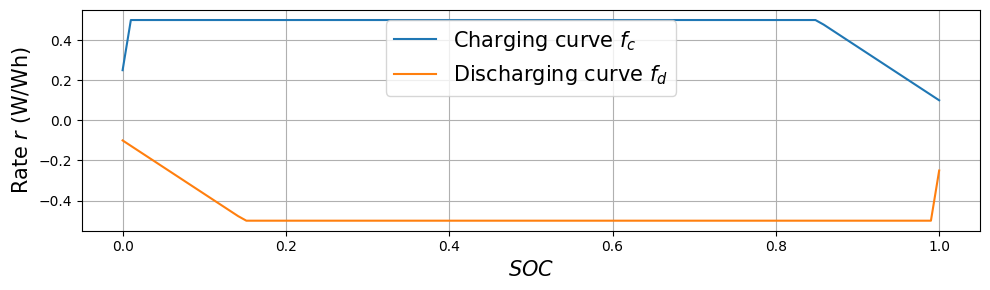

In [35]:
plt.figure(figsize=(10, 3))
plt.plot(
    np.linspace(0, 1, 100),
    SOC_to_CR_function(np.linspace(0, 1, 100)),
    label="Charging curve $f_c$",
)
plt.plot(
    np.linspace(0, 1, 100),
    -SOC_to_DR_function(np.linspace(0, 1, 100)),
    label="Discharging curve $f_d$",
)
plt.grid(True)
plt.xlabel("$SOC$", fontdict=dict(size=15))
plt.ylabel("Rate $r$ (W/Wh)", fontdict=dict(size=15))
plt.legend(loc="upper center", fontsize=15)
plt.tight_layout()
plt.savefig("out/charging_curve.pdf")
plt.show()

# Compute max SOC change in one hour of charge/ discharge

In [ ]:
Nint = 5
G_c, G_d = bat.get_max_SOC_change(Nint)


Nint2 = 100
G_c2, G_d2 = bat.get_max_SOC_change(Nint2)

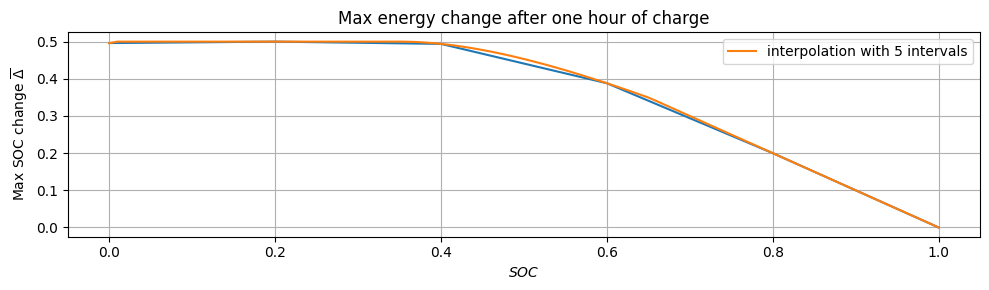

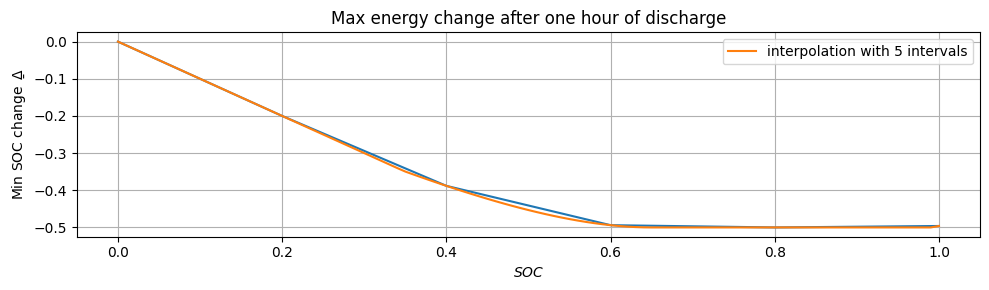

In [77]:
import matplotlib.pyplot as plt

plt.rc("text", usetex=False)

plt.figure(figsize=(10, 3))
plt.grid(True)
plt.plot(np.linspace(0, 1, Nint + 1), G_c)
plt.plot(
    np.linspace(0, 1, Nint2 + 1),
    G_c2,
    label="interpolation with {} intervals".format(Nint),
)
plt.ylabel(r"Max SOC change $\overline{\Delta}$")
plt.xlabel("$SOC$")
plt.title("Max energy change after one hour of charge")
plt.legend()
plt.tight_layout()
plt.savefig("out/max_energy_change.pdf")
plt.show()


plt.figure(figsize=(10, 3))
plt.grid(True)
plt.plot(np.linspace(0, 1, Nint + 1), G_d)
plt.plot(
    np.linspace(0, 1, Nint2 + 1),
    G_d2,
    label="interpolation with {} intervals".format(Nint),
)
plt.ylabel(r"Min SOC change   $\underbar \!\!\! \Delta $")
plt.xlabel("$SOC$")
plt.title("Max energy change after one hour of discharge")
plt.legend()
plt.tight_layout()
plt.savefig("out/min_energy_change.pdf")
plt.show()

# Dataset :

In [ ]:
country = "Germany"

In [ ]:
df = load_data(country=country, start="2021-01-01 00:00:00")
df

Country ISO3 Code           timestamp     Datetime (Local)  \
387912  Germany       DEU 2021-01-01 00:00:00  2021-01-01 01:00:00   
387913  Germany       DEU 2021-01-01 01:00:00  2021-01-01 02:00:00   
387914  Germany       DEU 2021-01-01 02:00:00  2021-01-01 03:00:00   
387915  Germany       DEU 2021-01-01 03:00:00  2021-01-01 04:00:00   
387916  Germany       DEU 2021-01-01 04:00:00  2021-01-01 05:00:00   
...         ...       ...                 ...                  ...   
405427  Germany       DEU 2022-12-31 19:00:00  2022-12-31 20:00:00   
405428  Germany       DEU 2022-12-31 20:00:00  2022-12-31 21:00:00   
405429  Germany       DEU 2022-12-31 21:00:00  2022-12-31 22:00:00   
405430  Germany       DEU 2022-12-31 22:00:00  2022-12-31 23:00:00   
405431  Germany       DEU 2022-12-31 23:00:00  2023-01-01 00:00:00   

        price_euros_wh       vgc  fgc  
387912        0.000048  0.000005    0  
387913        0.000045  0.000005    0  
387914        0.000043  0.000005    0  
387915        0.000040  0.000005    0  
387916        0.000040  0.000005    0  
...                ...       ...  ...  
405427        0.000023  0.000005    0  
405428       -0.000001  0.000005    0  
405429       -0.000001  0.000005    0  
405430        0.000025  0.000005    0  
405431       -0.000005  0.000005    0  

[17520 rows x 7 columns]

In [ ]:
import pandas as pd
import numpy as np
from amplpy import AMPL, modules
import datetime

import datetime
import pandas as pd
import numpy as np
from amplpy import AMPL, modules
import datetime

from src.optimize import get_daily_schedule


def run_heuristic(bat, df, start, end, df_history):
    """
    Run a simulation starting from the start-th day of the dataframe.
    For every day of the simulation, a schedule is generated (either based on true prices or prediction) and different
    metrics are recorded.
    We return a dataframe containing the results of the simulation
    """

    try:
        end = datetime.datetime.strptime(end, "%Y-%m-%d %H:%M:%S") - datetime.timedelta(
            hours=1
        )
        start_index = df.index.get_loc(df.index[df.timestamp == start][0])
        end_index = df.index.get_loc(df.index[df.timestamp == end][0])
    except:
        raise ValueError(
            "The dataframe does not contain all the data between the start and end dates"
        )
    start_df = start_index
    df = df.iloc[start_df : end_index + 1, :]
    n_hours = (end_index - start_df) + 1

    if n_hours % 24 != 0:
        raise Exception("The dataframe should contain only full days (24 hours)")

    bat.reset()  # start with a new battery, and get the max SOC change when charging and discharging

    n_cycles_list = np.zeros(n_hours)
    eff_list = np.zeros(n_hours)
    NEC_list = np.zeros(n_hours)
    schedule = np.zeros(n_hours)

    prices = (
        df_history.groupby([df_history.timestamp.dt.hour])
        .mean()
        .price_euros_wh.to_numpy()
    )
    vgc = df_history.groupby([df_history.timestamp.dt.hour]).mean().vgc.to_numpy()
    fgc = df_history.groupby([df_history.timestamp.dt.hour]).mean().fgc.to_numpy()
    bat.reset()  # start with a new battery, and get the max SOC change when charging and discharging
    G_c, G_d = bat.max_SOC_change_charge, bat.min_SOC_change_discharge
    daily_schedule = get_daily_schedule(prices, vgc, fgc, bat, G_c, G_d) / bat.init_NEC

    print(fgc, vgc)

    # optimization done for each day :
    for i, day in enumerate(range(0, n_hours // 24)):
        day_indices = slice(day * 24, (day + 1) * 24)

        # store battery state
        n_cycles_list[day_indices] = bat.n_cycles
        eff_list[day_indices] = bat.eff
        NEC_list[day_indices] = bat.NEC

        # get optimized schedule
        schedule[day_indices] = daily_schedule * bat.NEC

        bat.n_cycles += abs(daily_schedule).sum() / (2 * bat.init_NEC)

    ## store simulation results
    df = df.assign(
        n_cycles=n_cycles_list,
        eff=eff_list,
        NEC=NEC_list,
        schedule=schedule,
        capacity=np.hstack((np.array([0]), np.cumsum(schedule)[:-1])),
        SOC=lambda x: 100 * x.capacity / x.NEC,
        charge_energy=lambda x: x.schedule.mask(
            x.schedule < 0, 0
        ),  ## energy delivered to the battery
        discharge_energy=lambda x: -x.schedule.mask(x.schedule > 0, 0)
        * x.eff,  ## energy obtained from the battery (taking into account the discharge efficiency)
        electricity_revenue=lambda x: x.price_euros_wh
        * (  ## net revenue from electricity trading (before grid costs)
            x.discharge_energy - x.charge_energy
        ),
        grid_cost=lambda x: x.vgc
        * (x.discharge_energy + x.charge_energy)  ## grid costs
        + x.fgc * (abs(x.schedule) > 10**-5),
        variable_grid_cost=lambda x: x.vgc
        * (x.discharge_energy + x.charge_energy),  ## grid costs
        fixed_grid_cost=lambda x: x.fgc * (abs(x.schedule) > 10**-5),
        hourly_profit=lambda x: x.electricity_revenue - x.grid_cost,  ## profits
    )

    return df

In [ ]:
import pandas as pd
import numpy as np
from amplpy import AMPL, modules
import datetime

import datetime
import pandas as pd
import numpy as np
from amplpy import AMPL, modules
import datetime

from src.optimize import get_daily_schedule


def run_heuristic(bat, df, start, end, df_history):
    """
    Run a simulation starting from the start-th day of the dataframe.
    For every day of the simulation, a schedule is generated (either based on true prices or prediction) and different
    metrics are recorded.
    We return a dataframe containing the results of the simulation
    """

    try:
        end = datetime.datetime.strptime(end, "%Y-%m-%d %H:%M:%S") - datetime.timedelta(
            hours=1
        )
        start_index = df.index.get_loc(df.index[df.timestamp == start][0])
        end_index = df.index.get_loc(df.index[df.timestamp == end][0])
    except:
        raise ValueError(
            "The dataframe does not contain all the data between the start and end dates"
        )
    start_df = start_index
    df = df.iloc[start_df : end_index + 1, :]
    n_hours = (end_index - start_df) + 1

    if n_hours % 24 != 0:
        raise Exception("The dataframe should contain only full days (24 hours)")

    bat.reset()  # start with a new battery, and get the max SOC change when charging and discharging

    n_cycles_list = np.zeros(n_hours)
    eff_list = np.zeros(n_hours)
    NEC_list = np.zeros(n_hours)
    schedule = np.zeros(n_hours)

    bat.reset()  # start with a new battery, and get the max SOC change when charging and discharging

    G_c, G_d = bat.max_SOC_change_charge, bat.min_SOC_change_discharge
    G_c = interp1d(np.linspace(0, 1, 6), G_c)
    G_d = interp1d(np.linspace(0, 1, 6), G_d)

    # optimization done for each day :
    SOC = 0
    for i, day in enumerate(range(0, n_hours // 24)):
        day_indices = slice(day * 24, (day + 1) * 24)

        for h in range(day * 24, (day + 1) * 24):
            if df.price_euros_wh.iloc[h] < df.price_euros_wh.iloc[h - 1]:
                increment = G_c(SOC)
                SOC = SOC + increment
                schedule[h] = increment * bat.NEC
            else:
                decrement = G_d(SOC)
                SOC = SOC + decrement
                schedule[h] = decrement * bat.NEC

        # store battery state
        n_cycles_list[day_indices] = bat.n_cycles
        eff_list[day_indices] = bat.eff
        NEC_list[day_indices] = bat.NEC

        # get optimized schedule

        bat.n_cycles += abs(schedule[day_indices]).sum() / (2 * bat.init_NEC)

    ## store simulation results
    df = df.assign(
        n_cycles=n_cycles_list,
        eff=eff_list,
        NEC=NEC_list,
        schedule=schedule,
        capacity=np.hstack((np.array([0]), np.cumsum(schedule)[:-1])),
        SOC=lambda x: 100 * x.capacity / x.NEC,
        charge_energy=lambda x: x.schedule.mask(
            x.schedule < 0, 0
        ),  ## energy delivered to the battery
        discharge_energy=lambda x: -x.schedule.mask(x.schedule > 0, 0)
        * x.eff,  ## energy obtained from the battery (taking into account the discharge efficiency)
        electricity_revenue=lambda x: x.price_euros_wh
        * (  ## net revenue from electricity trading (before grid costs)
            x.discharge_energy - x.charge_energy
        ),
        grid_cost=lambda x: x.vgc
        * (x.discharge_energy + x.charge_energy)  ## grid costs
        + x.fgc * (abs(x.schedule) > 10**-5),
        variable_grid_cost=lambda x: x.vgc
        * (x.discharge_energy + x.charge_energy),  ## grid costs
        fixed_grid_cost=lambda x: x.fgc * (abs(x.schedule) > 10**-5),
        hourly_profit=lambda x: x.electricity_revenue - x.grid_cost,  ## profits
    )

    return df

# true prices :

In [ ]:
df_history = df[df.timestamp.dt.year == 2021]

df_optim = run_heuristic(
    bat,
    start="2022-01-01 00:00:00",
    end="2023-01-01 00:00:00",
    df=df,
    df_history=df_history,
)


display_schedule(df_optim, name=country + "_heuristic")
display_profit(df_optim, name=country + "_heuristic")

In [ ]:
frame_size_forecast = 28
update_period = 1

df_optim = run_simulation(
    bat,
    start="2022-01-01 00:00:00",
    end="2023-01-01 00:00:00",
    df=df,
    forecasted=False,
    frame_size=frame_size_forecast,
    update_period=update_period,
)


display_schedule(df_optim, name=country + "_optim_" + str(frame_size_forecast))
display_profit(df_optim, name=country + "_optim_" + str(frame_size_forecast))

Gurobi 10.0.0:Gurobi 10.0.0: optimal solution; objective 97.59291234
160 simplex iterations
1 branching nodes
absmipgap=1.42109e-14, relmipgap=0
Gurobi 10.0.0:Gurobi 10.0.0: optimal solution; objective 44.01021739
418 simplex iterations
1 branching nodes
Gurobi 10.0.0:Gurobi 10.0.0: optimal solution; objective 154.5624587
214 simplex iterations
1 branching nodes
absmipgap=1.08899e-07, relmipgap=7.0456e-10
Gurobi 10.0.0:Gurobi 10.0.0: optimal solution; objective 79.69728902
234 simplex iterations
1 branching nodes
absmipgap=1.42109e-14, relmipgap=0
Gurobi 10.0.0:Gurobi 10.0.0: optimal solution; objective 72.58543329
251 simplex iterations
1 branching nodes
Gurobi 10.0.0:Gurobi 10.0.0: optimal solution; objective 160.4771932
232 simplex iterations
1 branching nodes
absmipgap=2.84217e-14, relmipgap=0
Gurobi 10.0.0:Gurobi 10.0.0: optimal solution; objective 133.7426134
163 simplex iterations
1 branching nodes
absmipgap=2.84217e-14, relmipgap=0
Gurobi 10.0.0:Gurobi 10.0.0: optimal solution;

# Get Schedule with forecasted prices :

In [ ]:
for frame_size_forecast in []:
    update_period = 1

    df_pred = run_simulation(
        bat,
        start="2022-01-01 00:00:00",
        end="2023-01-01 00:00:00",
        df=df,
        forecasted=True,
        frame_size=frame_size_forecast,
        update_period=update_period,
    )

    display_schedule(df_pred, name=country + "_pred_" + str(frame_size_forecast))
    display_profit(df_pred, name=country + "_pred_" + str(frame_size_forecast))
    get_stats(df_pred, df_optim, name=country + "_" + str(frame_size_forecast))

Gurobi 10.0.0:Gurobi 10.0.0: optimal solution; objective 135.5313858
227 simplex iterations
1 branching nodes
absmipgap=2.84217e-14, relmipgap=0
Gurobi 10.0.0:Gurobi 10.0.0: optimal solution; objective 135.3782732
226 simplex iterations
1 branching nodes
Gurobi 10.0.0:Gurobi 10.0.0: optimal solution; objective 129.6992807
197 simplex iterations
1 branching nodes
Gurobi 10.0.0:Gurobi 10.0.0: optimal solution; objective 127.650348
196 simplex iterations
1 branching nodes
Gurobi 10.0.0:Gurobi 10.0.0: optimal solution; objective 120.6486452
250 simplex iterations
1 branching nodes
Gurobi 10.0.0:Gurobi 10.0.0: optimal solution; objective 116.1117193
251 simplex iterations
1 branching nodes
absmipgap=0.000110053, relmipgap=9.47819e-07
Gurobi 10.0.0:Gurobi 10.0.0: optimal solution; objective 114.4478181
222 simplex iterations
1 branching nodes
absmipgap=1.42109e-14, relmipgap=0
Gurobi 10.0.0:Gurobi 10.0.0: optimal solution; objective 112.7433399
237 simplex iterations
1 branching nodes
absmip

prediction_mae 82.5119460208741
relative_diff_profits -19.58153992899328
daily_profit_avg_pred 191.9827554354141
avg_daily_profit_optim 238.7297086588079
n_cycles_pred 687.5314496886687
n_cycles_optim 763.934130481094


In [ ]:
df_pred.iloc[:30]


Country ISO3 Code           timestamp     Datetime (Local)  \
396672  Germany       DEU 2022-01-01 00:00:00  2022-01-01 01:00:00   
396673  Germany       DEU 2022-01-01 01:00:00  2022-01-01 02:00:00   
396674  Germany       DEU 2022-01-01 02:00:00  2022-01-01 03:00:00   
396675  Germany       DEU 2022-01-01 03:00:00  2022-01-01 04:00:00   
396676  Germany       DEU 2022-01-01 04:00:00  2022-01-01 05:00:00   
396677  Germany       DEU 2022-01-01 05:00:00  2022-01-01 06:00:00   
396678  Germany       DEU 2022-01-01 06:00:00  2022-01-01 07:00:00   
396679  Germany       DEU 2022-01-01 07:00:00  2022-01-01 08:00:00   
396680  Germany       DEU 2022-01-01 08:00:00  2022-01-01 09:00:00   
396681  Germany       DEU 2022-01-01 09:00:00  2022-01-01 10:00:00   
396682  Germany       DEU 2022-01-01 10:00:00  2022-01-01 11:00:00   
396683  Germany       DEU 2022-01-01 11:00:00  2022-01-01 12:00:00   
396684  Germany       DEU 2022-01-01 12:00:00  2022-01-01 13:00:00   
396685  Germany       DEU 2022-01-01 13:00:00  2022-01-01 14:00:00   
396686  Germany       DEU 2022-01-01 14:00:00  2022-01-01 15:00:00   
396687  Germany       DEU 2022-01-01 15:00:00  2022-01-01 16:00:00   
396688  Germany       DEU 2022-01-01 16:00:00  2022-01-01 17:00:00   
396689  Germany       DEU 2022-01-01 17:00:00  2022-01-01 18:00:00   
396690  Germany       DEU 2022-01-01 18:00:00  2022-01-01 19:00:00   
396691  Germany       DEU 2022-01-01 19:00:00  2022-01-01 20:00:00   
396692  Germany       DEU 2022-01-01 20:00:00  2022-01-01 21:00:00   
396693  Germany       DEU 2022-01-01 21:00:00  2022-01-01 22:00:00   
396694  Germany       DEU 2022-01-01 22:00:00  2022-01-01 23:00:00   
396695  Germany       DEU 2022-01-01 23:00:00  2022-01-02 00:00:00   
396696  Germany       DEU 2022-01-02 00:00:00  2022-01-02 01:00:00   
396697  Germany       DEU 2022-01-02 01:00:00  2022-01-02 02:00:00   
396698  Germany       DEU 2022-01-02 02:00:00  2022-01-02 03:00:00   
396699  Germany       DEU 2022-01-02 03:00:00  2022-01-02 04:00:00   
396700  Germany       DEU 2022-01-02 04:00:00  2022-01-02 05:00:00   
396701  Germany       DEU 2022-01-02 05:00:00  2022-01-02 06:00:00   

        price_euros_wh       vgc  fgc  n_cycles       eff             NEC  \
396672        0.000041  0.000005    0  0.000000  0.990000  1000000.000000   
396673        0.000043  0.000005    0  0.000000  0.990000  1000000.000000   
396674        0.000045  0.000005    0  0.000000  0.990000  1000000.000000   
396675        0.000038  0.000005    0  0.000000  0.990000  1000000.000000   
396676        0.000040  0.000005    0  0.000000  0.990000  1000000.000000   
396677        0.000041  0.000005    0  0.000000  0.990000  1000000.000000   
396678        0.000043  0.000005    0  0.000000  0.990000  1000000.000000   
396679        0.000050  0.000005    0  0.000000  0.990000  1000000.000000   
396680        0.000070  0.000005    0  0.000000  0.990000  1000000.000000   
396681        0.000077  0.000005    0  0.000000  0.990000  1000000.000000   
396682        0.000084  0.000005    0  0.000000  0.990000  1000000.000000   
396683        0.000095  0.000005    0  0.000000  0.990000  1000000.000000   
396684        0.000097  0.000005    0  0.000000  0.990000  1000000.000000   
396685        0.000097  0.000005    0  0.000000  0.990000  1000000.000000   
396686        0.000101  0.000005    0  0.000000  0.990000  1000000.000000   
396687        0.000127  0.000005    0  0.000000  0.990000  1000000.000000   
396688        0.000150  0.000005    0  0.000000  0.990000  1000000.000000   
396689        0.000146  0.000005    0  0.000000  0.990000  1000000.000000   
396690        0.000140  0.000005    0  0.000000  0.990000  1000000.000000   
396691        0.000122  0.000005    0  0.000000  0.990000  1000000.000000   
396692        0.000103  0.000005    0  0.000000  0.990000  1000000.000000   
396693        0.000097  0.000005    0  0.000000  0.990000  1000000.000000   
396694        0.000085  0.000005    0  0.000000  0.990000  1000000